# Simulate acoustic wave propagation of a plane circular piston


The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook demonstrates a simulation with a plane circular piston source.

## Import the OptimUS library

Load the OptimUS library.

In [1]:
import optimus

## Specify a piston as acoustic source

The OptimUS library provides different predefined wave fields, among which is a plane circular piston radiating in 2*pi space. The piston requires the frequency to be specified and, optionally, the source axis, the velocity and its location, which is in this case at [-4, 0, 0].

In [2]:
frequency = 1000
radius = 1
location = (-4, 0, 0)
source = optimus.source.create_piston(frequency, radius=radius, location=location, source_axis = (1,0,0))

## Specify the physical settings for the simulation

Let us consider a spherical object with unit radius that resembles bone and is embedded in an unbounded region of water.

In [3]:
geometry = optimus.geometry.shapes.Sphere(element_size=0.4)
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. Let us use a model with default settings.

In [4]:
model = optimus.model.create_default_model(source, geometry, material_ext, material_int)

After creating the model, it needs to be solved to obtain the surface potentials at the material interface. Depending on the size of the model, this can be computationally expensive. The solution will be stored inside the model object.

In [5]:
model.solve()

## Visualisation of the acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $z=0$.

In [6]:
postprocess_plane = optimus.postprocess.VisualisePlane(model)
postprocess_plane.create_computational_grid(bounding_box=(-3, 5, -3, 3))
postprocess_plane.compute_fields()

Let us first visualise the incident field in the exterior domain.

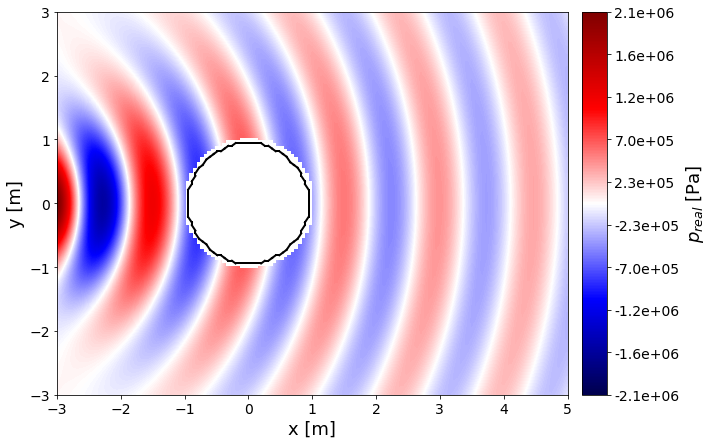

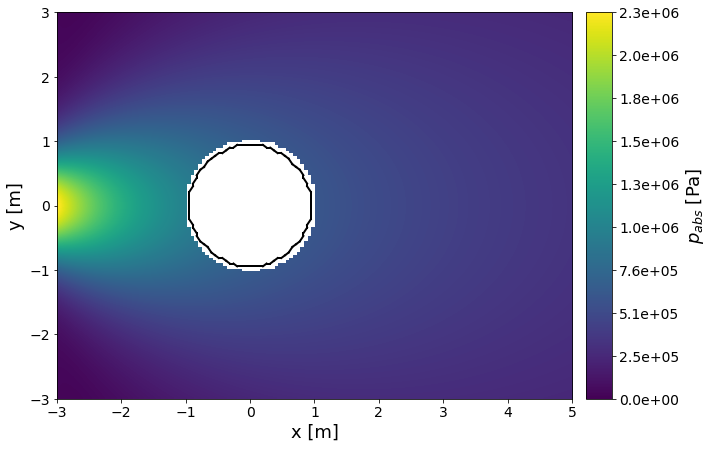

In [7]:
%matplotlib inline
figs = optimus.postprocess.plot_pressure_field(postprocess_plane, field="incident")

The pressure field in the entire domain is as follows.

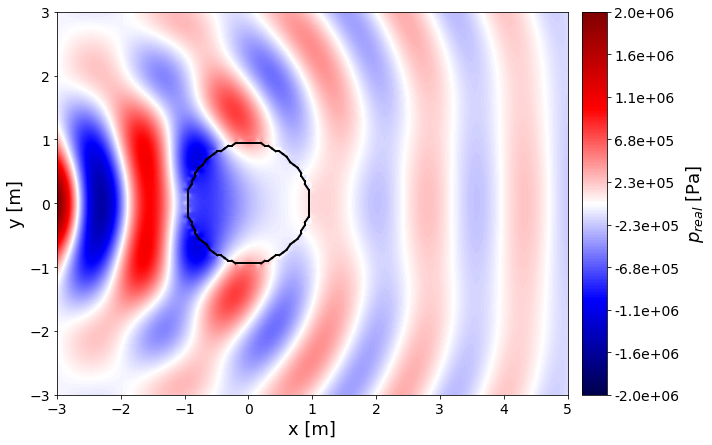

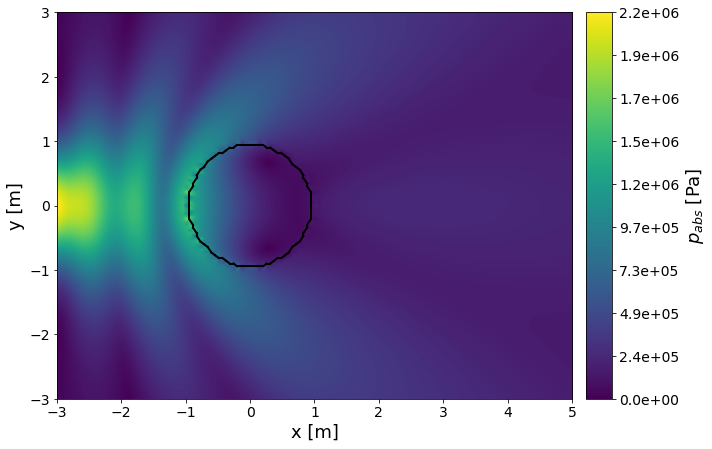

In [8]:
%matplotlib inline
figs = optimus.postprocess.plot_pressure_field(postprocess_plane, field="total")